# Analisi esplorativa e clustering

Questo notebook presenta l'analisi esplorativa del training set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.cm as cm
import seaborn as sns

import tqdm

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn.metrics.pairwise as pw

# %matplotlib inline

export_images = True
style = 'white'
img_folder = './img/'

# tune this for bigger figures
pl.rcParams['figure.figsize'] = (14, 14)
sns.set_context('notebook')

Carichiamo il dataset:

In [2]:
dataset_raw = pd.read_excel("./Dataset/finali/integrato_2014.xlsx", sheet_name='ML_finale')
dataset_raw.head()

,Country code,Country name,Population,CO2 production (kg),Charcoal consumption (kg),Fuel oil consumption (kg),Renewable energy consumption (percentage),PM2.5 (micrograms),GDP
0,AFG,Afghanistan,32758020,9.809225e+09,1.259260e+08,4.407000e+08,16.748996,49.026761,2.005019e+10
1,AGO,Angola,26920466,3.476316e+10,1.164000e+09,3.081000e+03,50.797466,35.129513,1.267770e+11
2,AND,Andorra,79223,4.620420e+08,2.900000e+04,1.299600e+02,19.886327,10.389338,3.350736e+09
3,ARE,United Arab Emirates,9070867,2.113695e+11,6.400000e+07,4.957000e+03,0.167807,67.175459,4.031980e+11
4,ARG,Argentina,42981515,2.040245e+11,4.940000e+08,9.759000e+03,10.773125,13.678616,5.263200e+11


Per comodità rinominiamo le colonne:

In [3]:
dataset_raw = dataset_raw.rename(columns={'CO2 production (kg)': 'CO2',
                           'Charcoal consumption (kg)': 'Charcoal',
                           'Fuel oil consumption (kg)': 'Fuel oil',
                           'Renewable energy consumption (percentage)': 'Clean energy',
                           'PM2.5 (micrograms)': 'PM2.5'})
dataset_raw.head()

,Country code,Country name,Population,CO2,Charcoal,Fuel oil,Clean energy,PM2.5,GDP
0,AFG,Afghanistan,32758020,9.809225e+09,1.259260e+08,4.407000e+08,16.748996,49.026761,2.005019e+10
1,AGO,Angola,26920466,3.476316e+10,1.164000e+09,3.081000e+03,50.797466,35.129513,1.267770e+11
2,AND,Andorra,79223,4.620420e+08,2.900000e+04,1.299600e+02,19.886327,10.389338,3.350736e+09
3,ARE,United Arab Emirates,9070867,2.113695e+11,6.400000e+07,4.957000e+03,0.167807,67.175459,4.031980e+11
4,ARG,Argentina,42981515,2.040245e+11,4.940000e+08,9.759000e+03,10.773125,13.678616,5.263200e+11


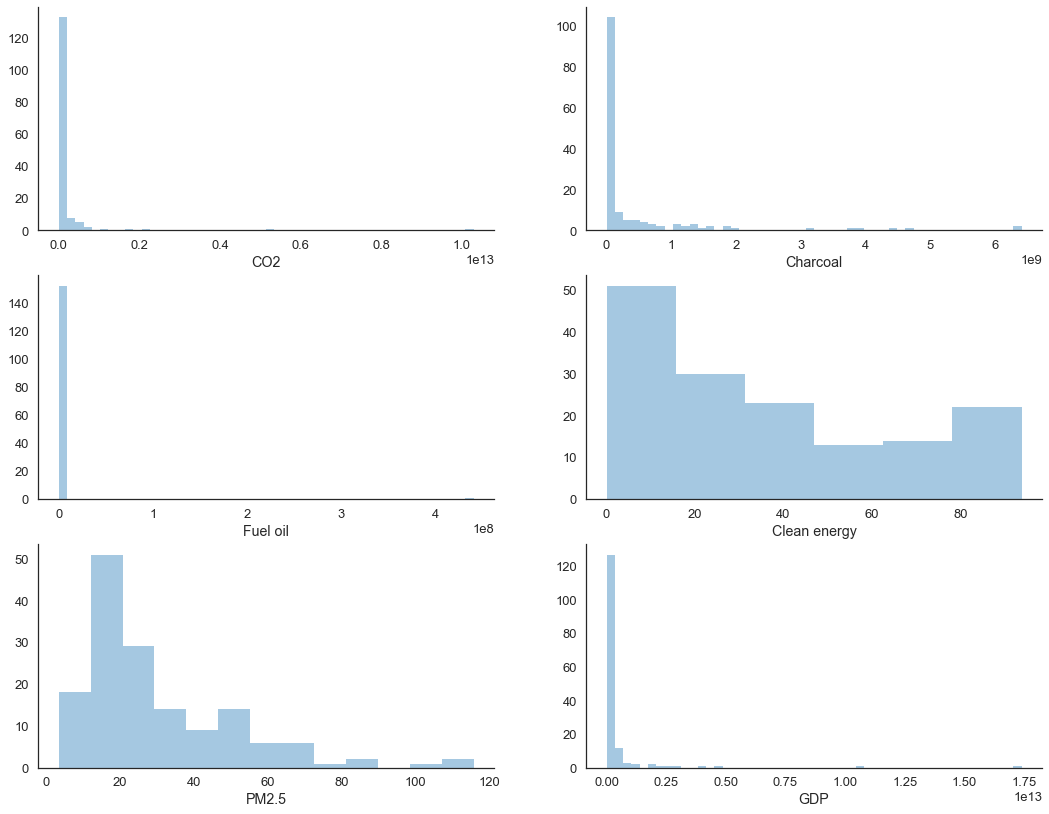

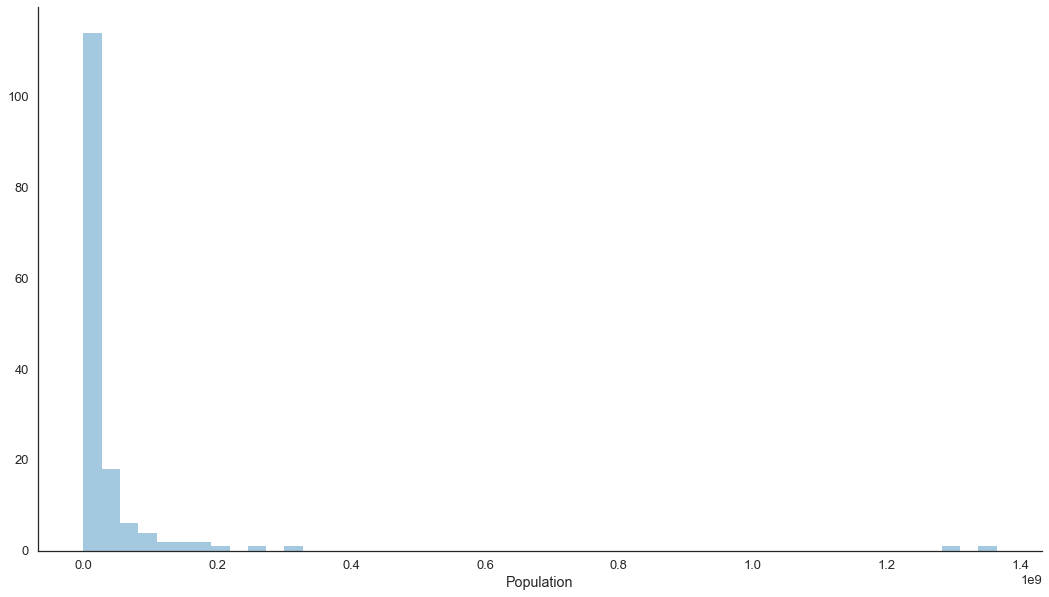

In [4]:
# Plot the original dataset
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')

    fig, ax = pl.subplots(3, 2, figsize=(18, 14))
    plot_kde = False
    sns.distplot(dataset_raw['CO2'], ax=ax[0, 0], kde=plot_kde)
    sns.distplot(dataset_raw['Charcoal'], ax=ax[0, 1], kde=plot_kde)
    sns.distplot(dataset_raw['Fuel oil'], ax=ax[1, 0], kde=plot_kde)
    sns.distplot(dataset_raw['Clean energy'], ax=ax[1, 1], kde=plot_kde)
    sns.distplot(dataset_raw['PM2.5'], ax=ax[2, 0], kde=plot_kde)
    sns.distplot(dataset_raw['GDP'], ax=ax[2, 1], kde=plot_kde)
    sns.despine()
    
    fig2, ax2 = pl.subplots(figsize=(18, 10))
    sns.distplot(dataset_raw['Population'], ax=ax2, kde=plot_kde)
    sns.despine()
    
    pl.show()

    if export_images:
        fig.savefig(img_folder + 'dataset-originale.png', bbox_inches='tight')
        fig2.savefig(img_folder + 'dataset-originale-popolazione.png', bbox_inches='tight')
        sns.set_context('notebook')

Vediamo le distribuzioni appaiate dei dati originali:

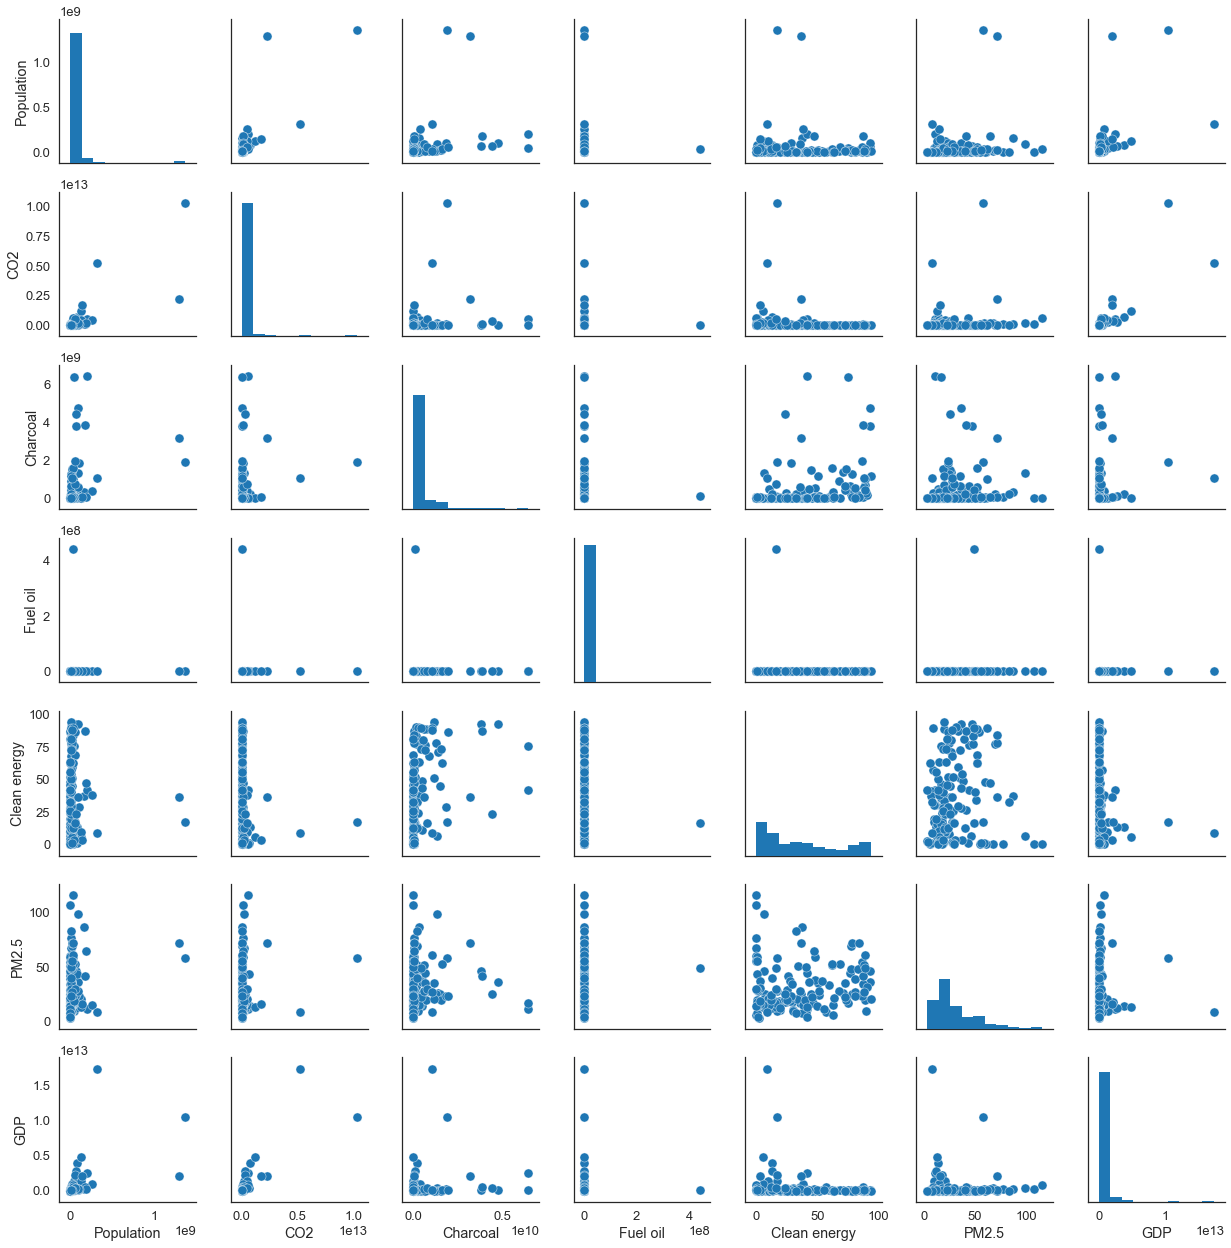

In [5]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')
    pairplot = sns.pairplot(dataset_raw)
    pl.show()
    
    if export_images:
        fig = pairplot.fig
        fig.savefig(img_folder + 'pairplot-originale.png', bbox_inches='tight')
        sns.set_context('notebook')

Normalizziamo gli attributi rispetto alla popolazione:

In [6]:
def normalize_with_col(dataset, ref_column=None, cols_to_normalize=None):
    """Divide all columns in a dataset for the normalization column."""
    if ref_column is None:
        raise ValueError("Must choose a reference column to normalize.")
    if cols_to_normalize is None:
        raise ValueError("Must select target columns.")

    norm_col = dataset[ref_column]
    result = dataset.copy()
    
    for col in cols_to_normalize:
        result[col] = result[col] / norm_col
    
    return result

In [7]:
dataset = normalize_with_col(dataset_raw,
                             ref_column='Population',
                             cols_to_normalize=['CO2', 'Charcoal', 'Fuel oil', 'GDP'])
# Peek at the data
dataset.head()

,Country code,Country name,Population,CO2,Charcoal,Fuel oil,Clean energy,PM2.5,GDP
0,AFG,Afghanistan,32758020,299.444991,3.844127,13.453194,16.748996,49.026761,612.069651
1,AGO,Angola,26920466,1291.328315,43.238479,0.000114,50.797466,35.129513,4709.316696
2,AND,Andorra,79223,5832.169951,0.366055,0.001640,19.886327,10.389338,42294.994724
3,ARE,United Arab Emirates,9070867,23302.022508,7.055555,0.000546,0.167807,67.175459,44449.775308
4,ARG,Argentina,42981515,4746.797455,11.493313,0.000227,10.773125,13.678616,12245.264040


## Statistiche descrittive per il dataset

Il dataset contiene 153 istanze di paesi, ognuna con gli attributi

- popolazione
- produzione di CO_2 annuale (in kg)
- consumo di carbone annuale (in kg)
- consumo di carburanti fossili annuale (in kg)
- percentuale di energia rinnovabile utilizzata, rispetto all'utilizzo totale di quel paese
- GDP (prodotto interno lordo)

Vediamo come sono distribuite le variabili.

In [8]:
dataset.describe()

,Population,CO2,Charcoal,Fuel oil,Clean energy,PM2.5,GDP
count,1.530000e+02,153.000000,153.000000,1.530000e+02,153.000000,153.000000,153.000000
mean,4.388212e+07,4190.103188,17.168798,8.814228e-02,35.687487,30.243552,11756.843728
std,1.560372e+08,6372.361344,25.588456,1.087609e+00,29.876964,21.074852,16910.303310
min,7.277800e+04,44.485376,0.008927,5.180149e-07,0.000000,3.397615,312.748979
25%,2.374419e+06,564.368357,1.077500,4.436075e-05,9.798903,15.780430,1569.928275
50%,9.474511e+06,1902.758910,3.325575,1.342412e-04,28.721289,23.062206,4712.822736
75%,2.832324e+07,5260.352041,29.347377,2.915885e-04,59.903202,39.944650,14201.434596
max,1.364270e+09,45423.239959,138.779013,1.345319e+01,93.859219,115.872278,97200.009655


#### Descrizione del vero dataset utilizzato per clustering

In [9]:
dataset.iloc[:, 3:].describe()

,CO2,Charcoal,Fuel oil,Clean energy,PM2.5,GDP
count,153.000000,153.000000,1.530000e+02,153.000000,153.000000,153.000000
mean,4190.103188,17.168798,8.814228e-02,35.687487,30.243552,11756.843728
std,6372.361344,25.588456,1.087609e+00,29.876964,21.074852,16910.303310
min,44.485376,0.008927,5.180149e-07,0.000000,3.397615,312.748979
25%,564.368357,1.077500,4.436075e-05,9.798903,15.780430,1569.928275
50%,1902.758910,3.325575,1.342412e-04,28.721289,23.062206,4712.822736
75%,5260.352041,29.347377,2.915885e-04,59.903202,39.944650,14201.434596
max,45423.239959,138.779013,1.345319e+01,93.859219,115.872278,97200.009655


Ora vediamo la distribuzione delle features:

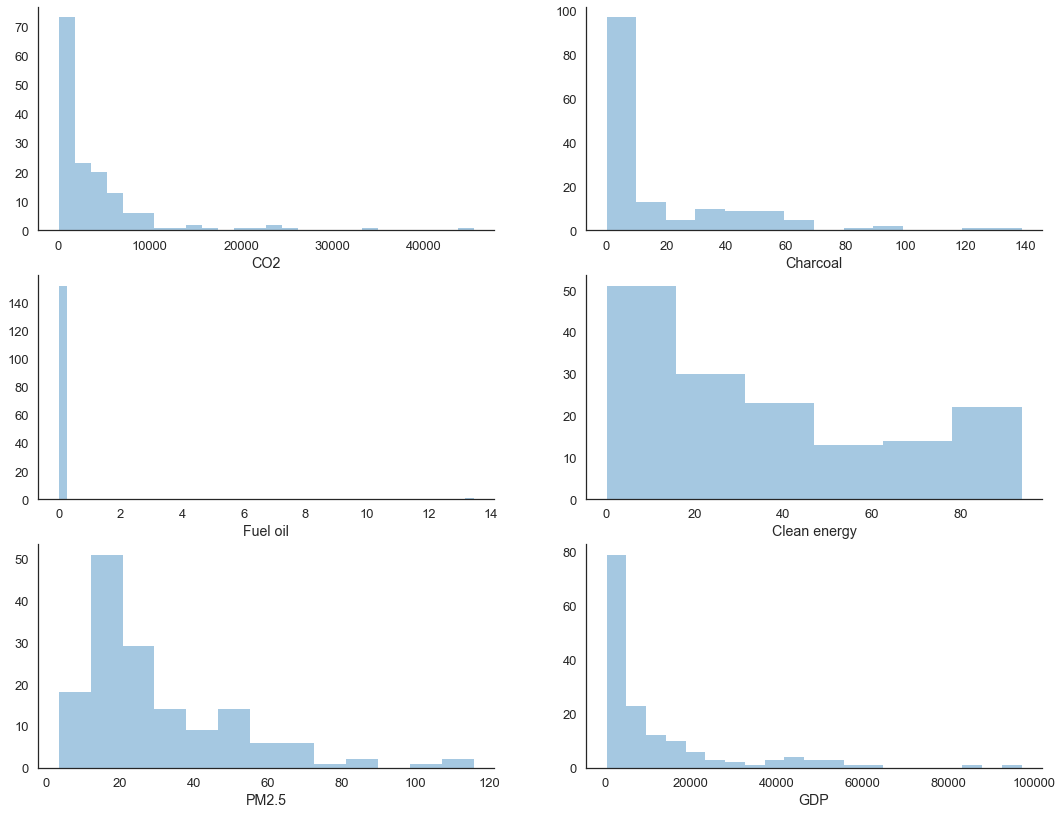

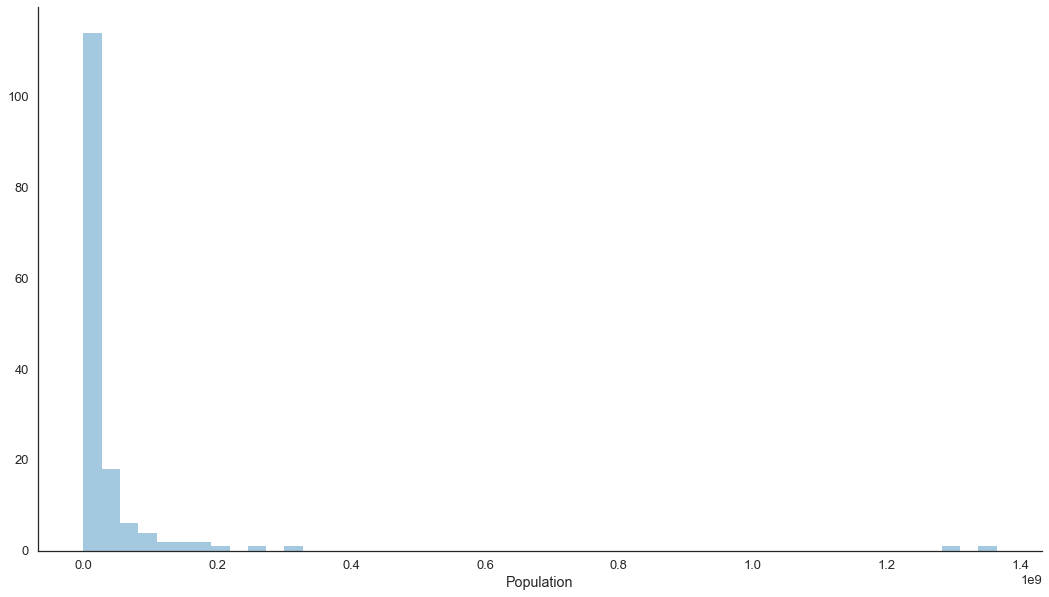

In [10]:
# Plot the population-scaled dataset
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')

    fig, ax = pl.subplots(3, 2, figsize=(18, 14))
    plot_kde = False
    sns.distplot(dataset['CO2'], ax=ax[0, 0], kde=plot_kde)
    sns.distplot(dataset['Charcoal'], ax=ax[0, 1], kde=plot_kde)
    sns.distplot(dataset['Fuel oil'], ax=ax[1, 0], kde=plot_kde)
    sns.distplot(dataset['Clean energy'], ax=ax[1, 1], kde=plot_kde)
    sns.distplot(dataset['PM2.5'], ax=ax[2, 0], kde=plot_kde)  # TODO: sistemare labels
    sns.distplot(dataset['GDP'], ax=ax[2, 1], kde=plot_kde)
    sns.despine()
    
    fig2, ax2 = pl.subplots(figsize=(18, 10))
    sns.distplot(dataset['Population'], ax=ax2, kde=plot_kde)
    sns.despine()
    
    pl.show()

    if export_images:
        fig.savefig(img_folder + 'dataset-scalato-popolazione.png', bbox_inches='tight')
        sns.set_context('notebook')

In [11]:
def standardize(dataset, cols_to_standardize=None):
    """Standardize dataset.
    
    Returns a new copy of the dataset with the
    selcted columns standardized.
    """
    if cols_to_standardize is None:
        raise ValueError("No column passed for standardization")

    result = dataset.copy()
    for col in cols_to_standardize:
        vals = preprocessing.scale(dataset[col].values)
        result.loc[:, col] = vals

    return result

In [12]:
dataset_std = standardize(dataset,
                          cols_to_standardize=[
                              'Population',
                              'CO2',
                              'Charcoal',
                              'Fuel oil',
                              'Clean energy',
                              'PM2.5',
                              'GDP'])
dataset_std.head()

/Users/pietro/Documents/Universita/Progetto_DT_ML/.venv/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


,Country code,Country name,Population,CO2,Charcoal,Fuel oil,Clean energy,PM2.5,GDP
0,AFG,Afghanistan,-0.071525,-0.612557,-0.522440,12.328828,-0.635964,0.894189,-0.661217
1,AGO,Angola,-0.109060,-0.456392,1.022152,-0.081203,0.507401,0.232600,-0.418128
2,AND,Andorra,-0.281643,0.258532,-0.658810,-0.079795,-0.530611,-0.945175,1.811821
3,ARE,United Arab Emirates,-0.223829,3.009039,-0.396525,-0.080804,-1.192769,1.758171,1.939663
4,ARG,Argentina,-0.005791,0.087648,-0.222527,-0.081099,-0.836637,-0.788586,0.028978


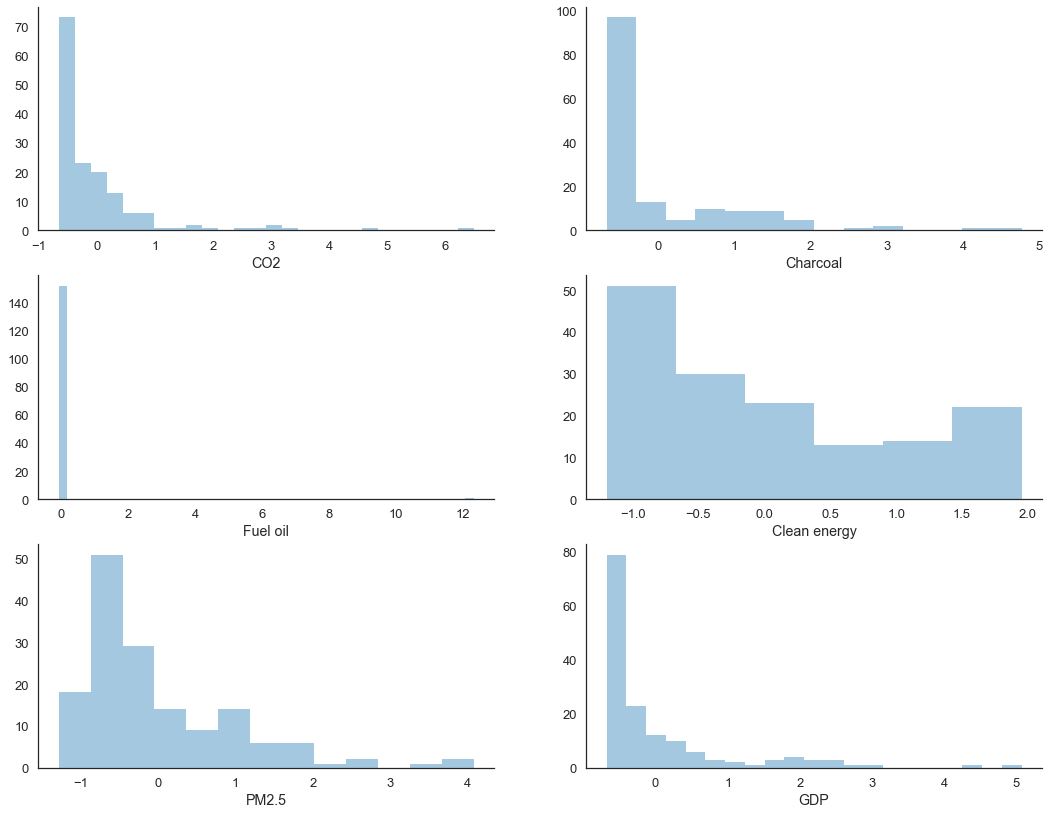

In [13]:
# Plot the standardized population-scaled dataset
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')

    fig, ax = pl.subplots(3, 2, figsize=(18, 14))
    plot_kde = False
    sns.distplot(dataset_std['CO2'], ax=ax[0, 0], kde=plot_kde)
    sns.distplot(dataset_std['Charcoal'], ax=ax[0, 1], kde=plot_kde)
    sns.distplot(dataset_std['Fuel oil'], ax=ax[1, 0], kde=plot_kde)
    sns.distplot(dataset_std['Clean energy'], ax=ax[1, 1], kde=plot_kde)
    sns.distplot(dataset_std['PM2.5'], ax=ax[2, 0], kde=plot_kde)  # TODO: sistemare labels
    sns.distplot(dataset_std['GDP'], ax=ax[2, 1], kde=plot_kde)
    sns.despine()
    pl.show()

    if export_images:
        fig.savefig(img_folder + 'dataset-std.png', bbox_inches='tight')
        sns.set_context('notebook')

#### Pairplot del dataset standardizzato

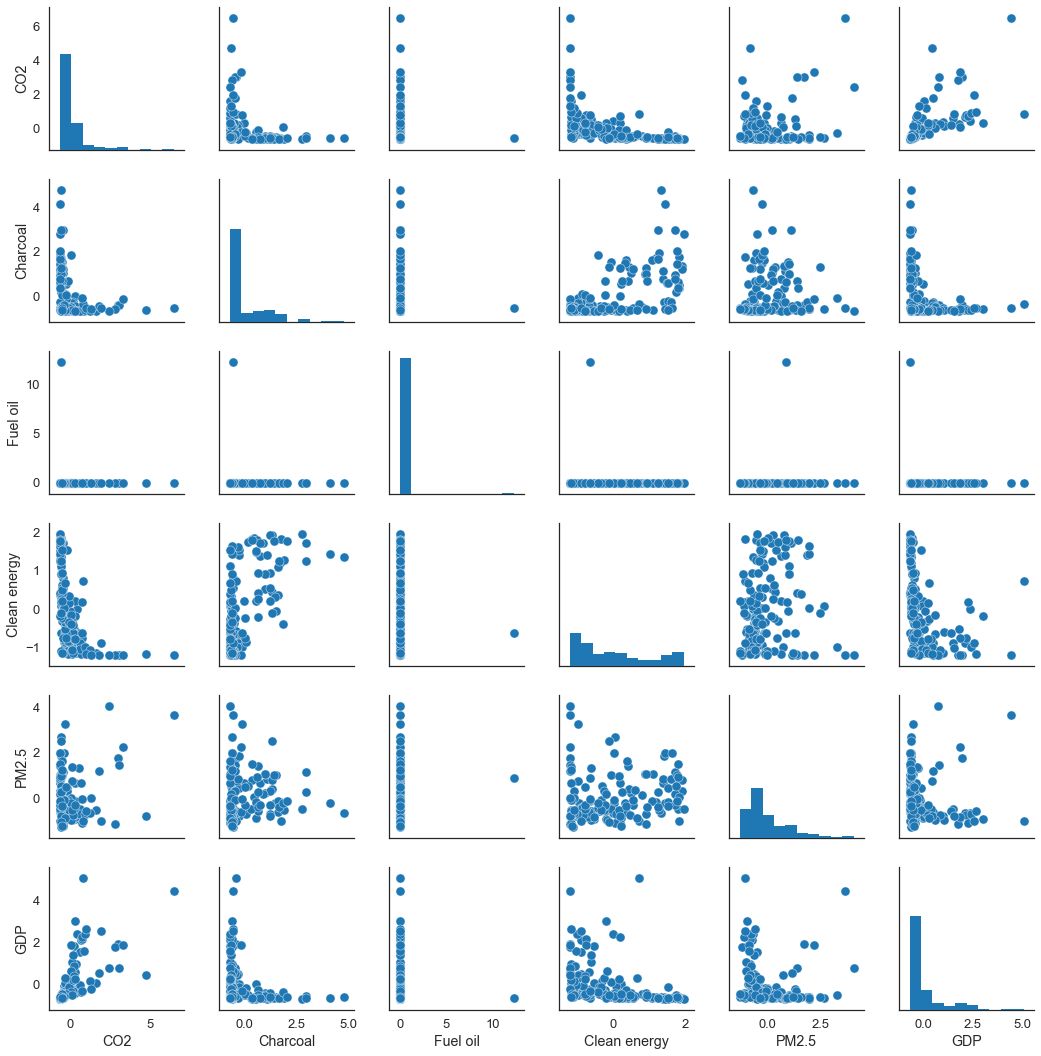

In [14]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')
    pairplot = sns.pairplot(dataset_std.loc[:,
                                           ['CO2',
                                           'Charcoal',
                                           'Fuel oil',
                                           'Clean energy',
                                           'PM2.5',
                                           'GDP']])
    pl.show()
    
    if export_images:
        fig = pairplot.fig
        fig.savefig(img_folder + 'pairplot-std.png', bbox_inches='tight')
        sns.set_context('notebook')

#### Pairplot del dataset non standardizzato

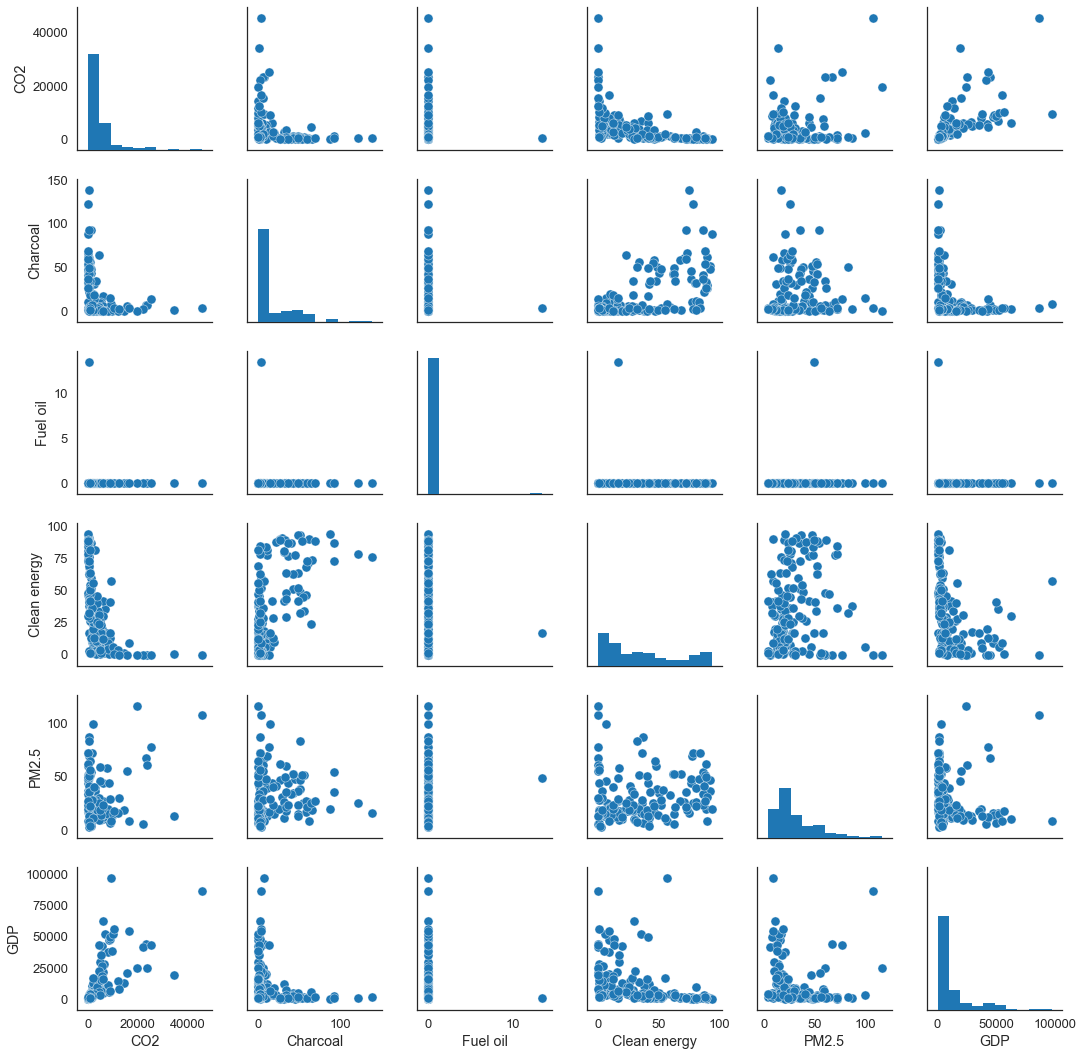

In [15]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')
    pairplot = sns.pairplot(dataset.loc[:,
                                           ['CO2',
                                           'Charcoal',
                                           'Fuel oil',
                                           'Clean energy',
                                           'PM2.5',
                                           'GDP']])
    pl.show()
    
    if export_images:
        fig = pairplot.fig
        fig.savefig(img_folder + 'pairplot-non-std.png', bbox_inches='tight')
        sns.set_context('notebook')

## Correlazione tra features

Esploriamo la correlazione tra le features con una heatmap:

In [16]:
def create_heatmap(dataset, figsize=(14, 14)):
    """Create a heatmap from the dataset."""
    # Compute the correlation matrix
    corr = dataset.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = pl.subplots(figsize=figsize)
    
    # Generate a custom diverging colormap
    cmap = sns.color_palette("RdBu")
    
    # Draw the heatmap with the mask and correct aspect ratio
    hm = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, cmap=cmap, annot=True,
                     square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return hm

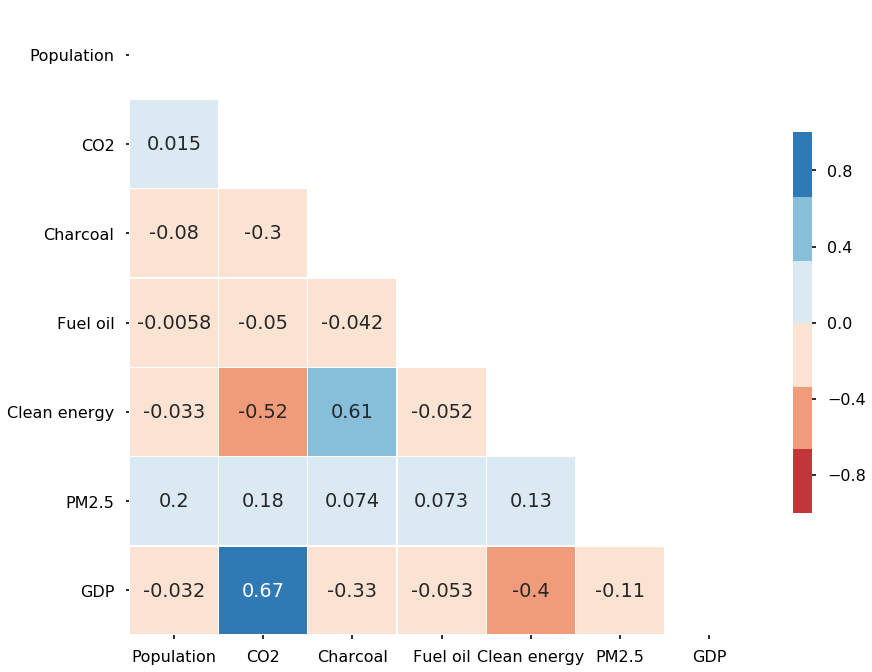

In [17]:
if export_images:
    sns.set_context('poster')
    
heatmap = create_heatmap(dataset)

if export_images:
    fig = heatmap.figure
    fig.savefig(img_folder + 'correlazione.png', bbox_inches='tight')
    sns.set_context('notebook')

# K-Means con Scikit-Learn

Ora che abbiamo esplotato il dataset, utilizziamo Sklearn per indurre un modello K-Means.

### Selezione delle feature

Da quanto emerge dall'analisi esplorativa, la feature "Fuel Oil Consumption" è estremamente sbilanciata verso lo zero, con solo l'Afghanistan a superare quota 10 kg per-capita.

In base a ciò, si è deciso di **eliminare la feature e ritenere soltanto le altre**, scalate rispetto alla popolazione e **standardizzate**.

In [18]:
data_km = dataset_std.copy()
data_km = data_km.drop(columns=['Fuel oil', 'Population'])
data_km.head()

,Country code,Country name,CO2,Charcoal,Clean energy,PM2.5,GDP
0,AFG,Afghanistan,-0.612557,-0.522440,-0.635964,0.894189,-0.661217
1,AGO,Angola,-0.456392,1.022152,0.507401,0.232600,-0.418128
2,AND,Andorra,0.258532,-0.658810,-0.530611,-0.945175,1.811821
3,ARE,United Arab Emirates,3.009039,-0.396525,-1.192769,1.758171,1.939663
4,ARG,Argentina,0.087648,-0.222527,-0.836637,-0.788586,0.028978


Come esperimento comparativo, teniamo anche un dataset non standardizzato per il clustering.

In [19]:
data_km_non_std = dataset.copy()
data_km_non_std = data_km_non_std.drop(columns=['Fuel oil', 'Population'])
data_km_non_std.head()

,Country code,Country name,CO2,Charcoal,Clean energy,PM2.5,GDP
0,AFG,Afghanistan,299.444991,3.844127,16.748996,49.026761,612.069651
1,AGO,Angola,1291.328315,43.238479,50.797466,35.129513,4709.316696
2,AND,Andorra,5832.169951,0.366055,19.886327,10.389338,42294.994724
3,ARE,United Arab Emirates,23302.022508,7.055555,0.167807,67.175459,44449.775308
4,ARG,Argentina,4746.797455,11.493313,10.773125,13.678616,12245.264040


### Pair-wise plot delle feature scelte


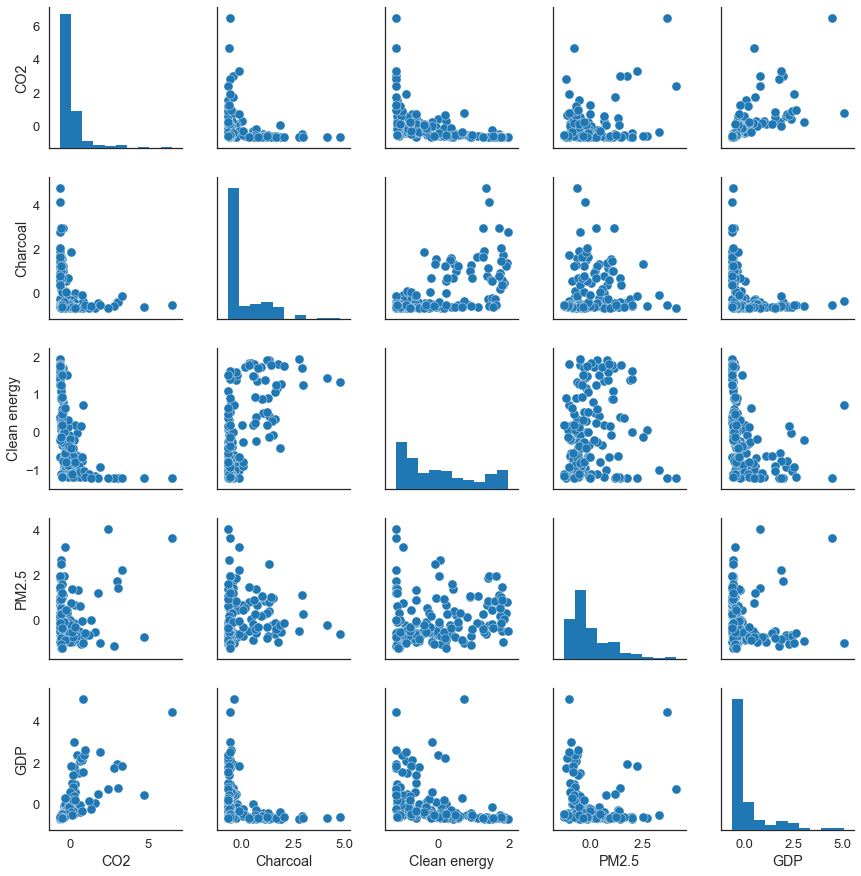

In [20]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')
    pairplot = sns.pairplot(data_km, size=2.5)
    pl.show()
    
    if export_images:
        fig = pairplot.fig
        fig.savefig(img_folder + 'pairplot-KMeans.png', bbox_inches='tight')
        sns.set_context('notebook')

## Clustering

Ora che il dataset è standardizzato, procediamo a clusterizzare.

Per trovare la migliore clusterizzazoine, creiamo una funzione.

In [22]:
def clusterize(X, min_clusters, max_clusters):
    n_clusters = list(range(min_clusters, max_clusters + 1))
    
    # (i, j) -> label for data point i when using n_clusters[j] clusters
    labels = np.zeros((X.shape[0], len(n_clusters)), dtype=np.int16)
    
    # (0, j) -> average silhouette score when using n_clusters[j] clusters
    silh_tot = np.zeros((1, len(n_clusters)))
    
    # (i, j) -> silhouette score for data point i when using n_clusters[j] clusters
    silh_ith = np.zeros((X.shape[0], len(n_clusters)))
    
    for ind, n in enumerate(tqdm.tqdm_notebook(n_clusters)):
        clusterer = KMeans(n_clusters=n, init='k-means++', n_init=10,
                           max_iter=100000, tol=1e-7,
                           precompute_distances=True, random_state=10,
                           n_jobs=1)
        
        curr_labels = clusterer.fit_predict(X)
        labels[:, ind] = curr_labels

        silhouette_avg = silhouette_score(X, curr_labels)
        silh_tot[0, ind] = silhouette_avg

        curr_silhouette_values = silhouette_samples(X, curr_labels)
        silh_ith[:, ind] = curr_silhouette_values

    ret_labels = pd.DataFrame(data=labels, columns=n_clusters)
    ret_silh_avg = pd.DataFrame(data=silh_tot, columns=n_clusters)
    ret_silh_point = pd.DataFrame(data=silh_ith, columns=n_clusters)

    return ret_labels, ret_silh_avg, ret_silh_point

Ora lanciamo il K-Means su un numero variabile di clusters, da 2 a 100. Vediamo poi quale è il migliore con l'indice di silhouette

In [23]:
data_values = data_km[['CO2', 'Charcoal', 'Clean energy', 'PM2.5', 'GDP']].values
labels, avg_silhouette, point_silhouette = clusterize(data_values, 2, 50)

HBox(children=(IntProgress(value=0, max=49), HTML(value='')))

In [24]:
data_values_ns = data_km_non_std[['CO2', 'Charcoal', 'Clean energy', 'PM2.5', 'GDP']].values
labels_ns, avg_silhouette_ns, point_silhouette_ns = clusterize(data_values_ns, 2, 50)

HBox(children=(IntProgress(value=0, max=49), HTML(value='')))

In [25]:
best_index = np.argmax(avg_silhouette.values)
best_silhouette = avg_silhouette.iloc[0, best_index]
best_n_cluster = avg_silhouette.columns[best_index]

best_cluster_labels = labels[labels.columns[best_index]].values

print("Standardized clustering")
print("Best silhouette score is {:6.4f} with {} clusters"
     .format(best_silhouette, best_n_cluster))

Standardized clustering
Best silhouette score is 0.3929 with 4 clusters


In [26]:
best_index_ns = np.argmax(avg_silhouette_ns.values)
best_silhouette_ns = avg_silhouette_ns.iloc[0, best_index_ns]
best_n_cluster_ns = avg_silhouette_ns.columns[best_index_ns]

best_cluster_labels_ns = labels_ns[labels_ns.columns[best_index_ns]].values

print("Non standardized clustering")
print("Best silhouette score is {:6.4f} with {} clusters"
     .format(best_silhouette_ns, best_n_cluster_ns))

Non standardized clustering
Best silhouette score is 0.7618 with 2 clusters


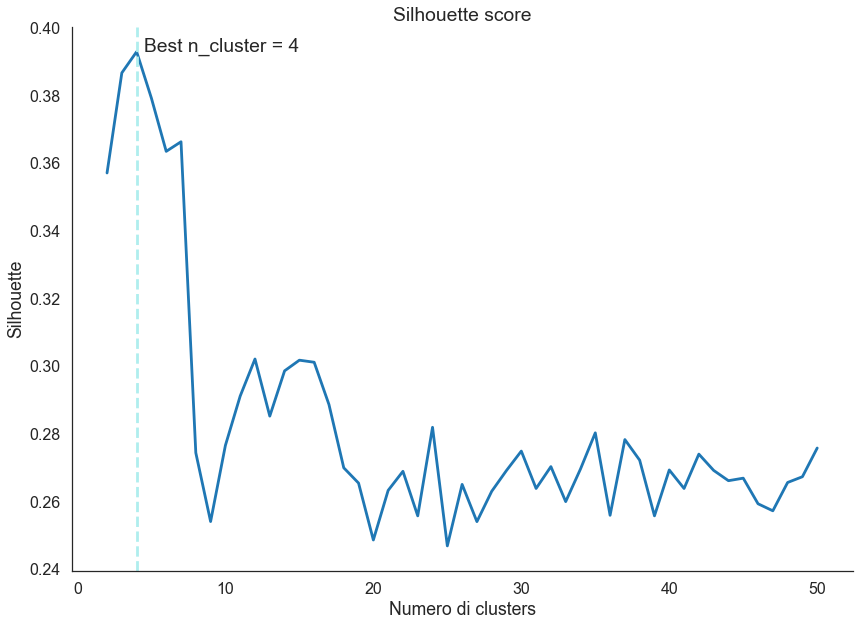

In [54]:
### Plot andamento silhouette media con il numero di clusters
with sns.axes_style(style):
    if export_images:
        sns.set_context('poster')

    avg_silh_plot = avg_silhouette.loc[0, :].values
    fig, ax = pl.subplots(ncols=1, figsize=(14, 10))
    pl.plot(np.array(avg_silhouette.columns.tolist()), avg_silh_plot)
    ax.axvline(x=avg_silhouette.columns.tolist()[np.argmax(avg_silh_plot)], color='paleturquoise', linestyle='--')
    ax.text(np.argmax(avg_silh_plot) + 2.5, np.max(avg_silh_plot), "Best n_cluster = 4")
    pl.xlabel("Numero di clusters")
    pl.ylabel("Silhouette")
    ax.set_title("Silhouette score")
    sns.despine()
    
    pl.show()
    
    if export_images:
        fig.savefig(img_folder + 'silhouette_vs_nclusters.png', bbox_inches='tight')
        sns.set_context('notebook')

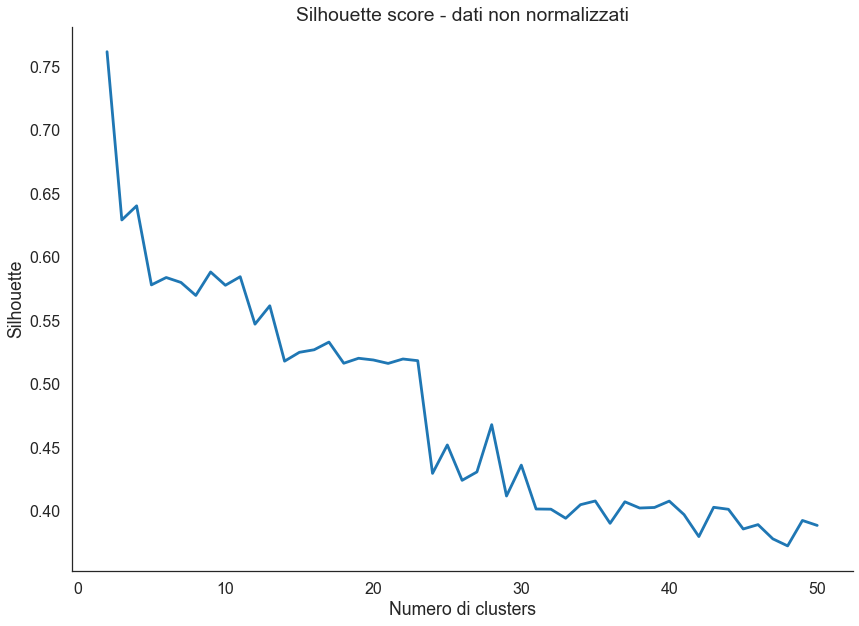

In [55]:
### Plot andamento silhouette media con il numero di clusters
with sns.axes_style(style):
    if export_images:
        sns.set_context('poster')

    avg_silh_plot_ns = avg_silhouette_ns.loc[0, :].values
    fig, ax = pl.subplots(ncols=1, figsize=(14, 10))
    pl.plot(np.array(avg_silhouette_ns.columns.tolist()), avg_silh_plot_ns)
    pl.xlabel("Numero di clusters")
    pl.ylabel("Silhouette")

    ax.set_title("Silhouette score - dati non normalizzati")
    sns.despine()
    
    pl.show()
    
    if export_images:
        #fig.savefig(img_folder + 'silhouette_vs_nclusters.png', bbox_inches='tight')
        sns.set_context('notebook')

### Plot dei valori di silhouette

Definiamo una funzione per plottare la silhouette:

In [56]:
# define a function that outputs the silhouette values for each cluster
def silhouette_for_clusters(labels, silhouettes):
    if len(labels) != len(silhouettes):
        raise ValueError("Lenght of labels ({}) differs from length of silhouettes ({})"
                        .format(len(labels), len(silhouettes)))

    cluster_names, cluster_size = np.unique(labels, return_counts=True)
    cluster_silh = {n: np.mean(silhouettes[labels == n]) for n in cluster_names}
    
    return cluster_silh, cluster_size

In [57]:
cluster_silh, cluster_size = silhouette_for_clusters(
    best_cluster_labels,
    point_silhouette[best_n_cluster].values
)

cluster_silh_ns, cluster_size_ns = silhouette_for_clusters(
    best_cluster_labels_ns,
    point_silhouette_ns[best_n_cluster_ns].values
)

In [58]:
print("Ci sono {} clusters per il dataset standardizzato.\n".format(len(cluster_size)))
for ind, size in enumerate(cluster_size):
        print("Cluster {} ha {:3d} elementi e silhouette = {:6.4f}".format(ind, size, cluster_silh[ind]))

Ci sono 4 clusters per il dataset standardizzato.

Cluster 0 ha  81 elementi e silhouette = 0.4255
Cluster 1 ha  48 elementi e silhouette = 0.3409
Cluster 2 ha  17 elementi e silhouette = 0.4501
Cluster 3 ha   7 elementi e silhouette = 0.2342


In [59]:
print("Ci sono {} clusters per il dataset non standardizzato.\n".format(len(cluster_size_ns)))
for ind, size in enumerate(cluster_size_ns):
        print("Cluster {} ha {:3d} elementi e silhouette = {:6.4f}".format(ind, size, cluster_silh_ns[ind]))

Ci sono 2 clusters per il dataset non standardizzato.

Cluster 0 ha  23 elementi e silhouette = 0.4079
Cluster 1 ha 130 elementi e silhouette = 0.8244


In [78]:
def plot_silhouette(cluster_labels, avg_silh, point_silh, cluster_silh, n_clusters, fig, ax, context, palette=None):
    """Make a silhouette plot.
    
    Parameters
    ----------
    data: pd.DataFrame
        data corresponding to the plots
        
    cluster_labels: np.array of shape (n_points, 1)
        labels of the cluster for each data point
    
    point_silh: np.array (n_points, 1)
        silhouette for each data point at the defined cluster number n_clusters
    
    avg_silh: float
        average silhouette score for this clusterization
    """
    min_silh_score = point_silh.min()
    max_silh_score = point_silh.max()
    
    ax.set_xlim([min_silh_score, max_silh_score])
    ax.set_ylim([0, len(cluster_labels) + (n_clusters + 1) * 10])
    
    y_lower = 10
    if not palette:
        palette = sns.color_palette('pastel', n_clusters)
    
    for i in range(n_clusters):
        # aggregate silhouette by cluster label and sort it
        silh_values_cluster_i = point_silh[cluster_labels == i]
        silh_values_cluster_i.sort()
        
        ith_cluster_size = silh_values_cluster_i.shape[0]
        y_upper = y_lower + ith_cluster_size
        
        color = palette[i]#cm.spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                        0, silh_values_cluster_i,
                        facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label with the cluster number in the middle
        text_x = -0.09 if context != 'talk' else -0.11
        text = "Cluster {}\nsilhouette = {:4.2f}".format(str(i), cluster_silh[i])
        ax.text(text_x, y_lower + 0.5 * ith_cluster_size, text)
        y_lower = y_upper + 10
    
    ax.set_title("Silhouette plot con {} clusters".format(n_clusters))
#    ax.set_yticks([])
    ax.axvline(x=avg_silh, color='paleturquoise', linestyle='--')
    
    return fig, ax

Vediamo la silhouette dei cluster sul dataset standardizzato:

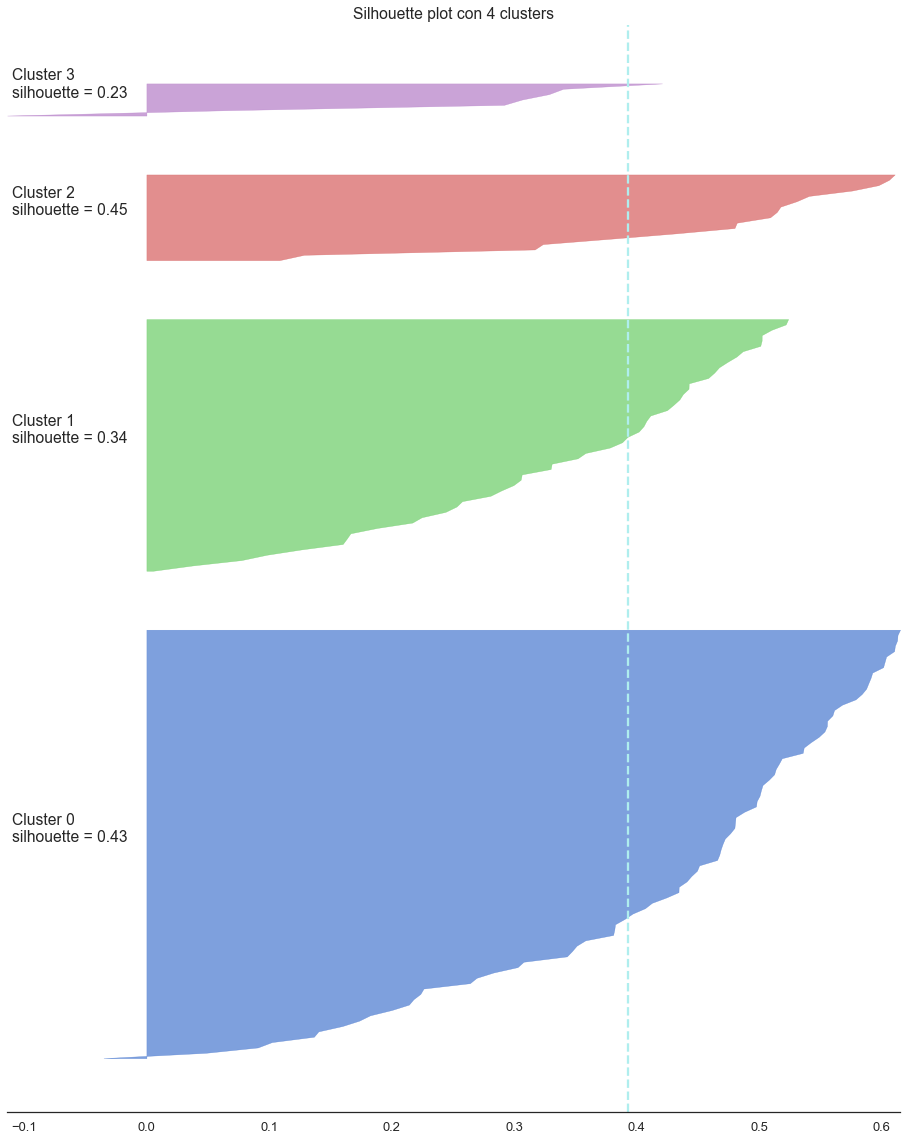

In [83]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')

    fig, ax = pl.subplots(ncols=1, figsize=(16, 20))
    plot_silhouette(labels[best_n_cluster].values,
                    avg_silhouette[best_n_cluster].values,
                    point_silhouette[best_n_cluster].values,
                    cluster_silh,
                    best_n_cluster,
                    fig, ax, 'talk',
                   palette=sns.color_palette('muted', best_n_cluster))
    sns.despine()
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    pl.show()
    
    if export_images:
        fig.savefig(img_folder + 'Silhouette.png', bbox_inches='tight')
        sns.set_context('notebook')

Vediamo la silhouette per i cluster creati sul dataset non standardizzato:

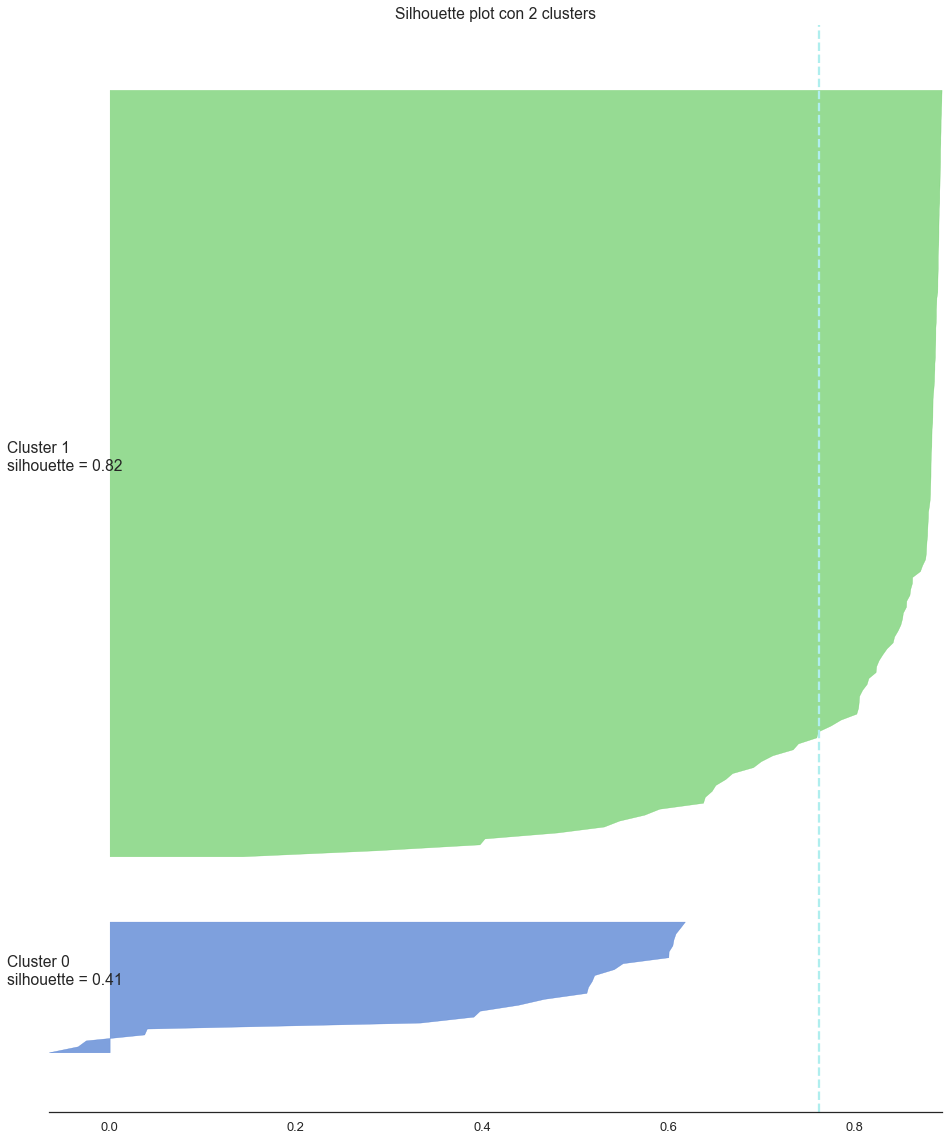

In [84]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')

    fig, ax = pl.subplots(ncols=1, figsize=(16, 20))
    plot_silhouette(labels_ns[best_n_cluster_ns].values,
                    avg_silhouette_ns[best_n_cluster_ns].values,
                    point_silhouette_ns[best_n_cluster_ns].values,
                    cluster_silh_ns,
                    best_n_cluster_ns,
                    fig, ax, 'talk',
                   palette=sns.color_palette('muted', best_n_cluster))
    sns.despine()
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    pl.show()
    
    if export_images:
        #fig.savefig(img_folder + 'Silhouette.png', bbox_inches='tight')
        sns.set_context('notebook')

Aggiungo la colonna con i labels al dataset:

In [86]:
data_final = data_km.copy()
data_final['cluster'] = best_cluster_labels
data_final.head()

,Country code,Country name,CO2,Charcoal,Clean energy,PM2.5,GDP,cluster
0,AFG,Afghanistan,-0.612557,-0.522440,-0.635964,0.894189,-0.661217,0
1,AGO,Angola,-0.456392,1.022152,0.507401,0.232600,-0.418128,1
2,AND,Andorra,0.258532,-0.658810,-0.530611,-0.945175,1.811821,2
3,ARE,United Arab Emirates,3.009039,-0.396525,-1.192769,1.758171,1.939663,3
4,ARG,Argentina,0.087648,-0.222527,-0.836637,-0.788586,0.028978,0


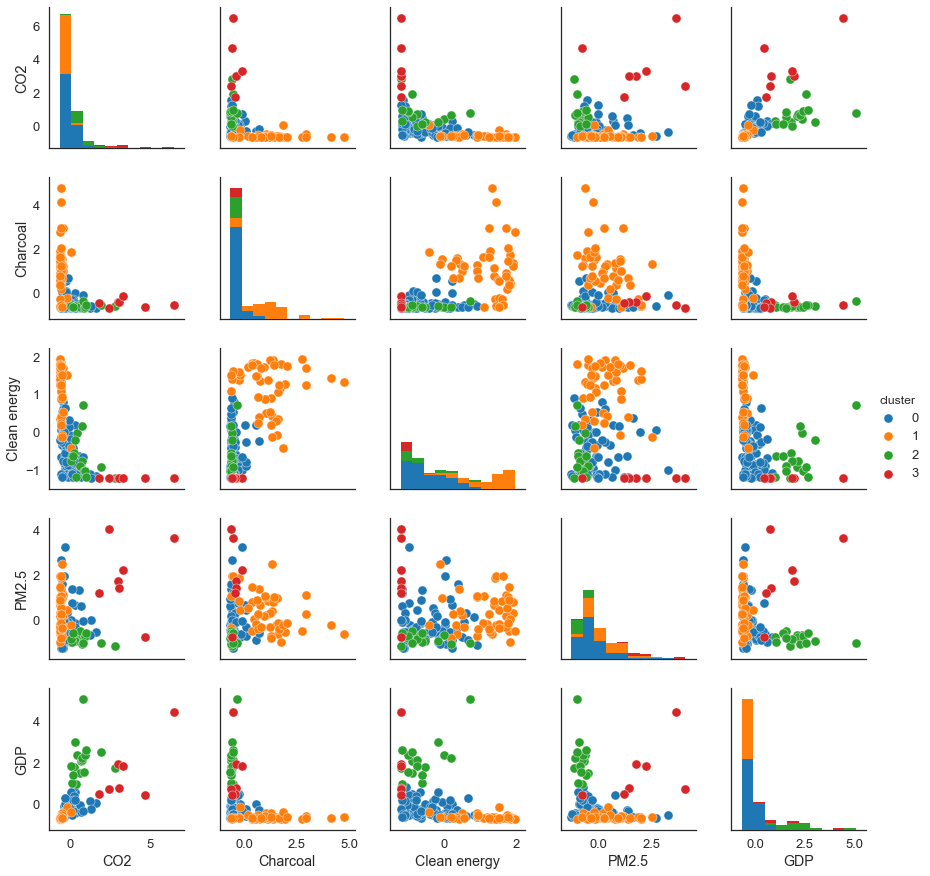

In [87]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('talk')
    pairplot = sns.pairplot(data_final,
                            vars=['CO2', 'Charcoal', 'Clean energy', 'PM2.5', 'GDP'],
                            hue='cluster')
    pl.show()
    
    if export_images:
        fig = pairplot.fig
        fig.savefig(img_folder + 'pairplot-KMeans-con-clusters.png', bbox_inches='tight')
        sns.set_context('notebook')

Per i dati non standardizzati ci sono solo 2 cluster:

In [90]:
def create_similarity_matrix(data):
    """Create a dissimilarity matrix from the input data,
    considered as (n_samples, n_features)
    """
    distances = pw.pairwise_distances(data, metric='euclidean', n_jobs=1)
    similarity = np.max(distances) - distances
    return similarity
    
def create_distance_matrix(data):
    """Create a distance matrix from the data, considered as (n_samples, n_features)."""
    distances = pw.pairwise_distances(data, metric='euclidean', n_jobs=1)
    return distances

Creiamo la matrice di dissimilarità (o delle distanze):

In [91]:
dissimilarity_matrix = create_distance_matrix(data_values)
similarity_matrix = create_similarity_matrix(data_values)

Plottiamo la matrice.

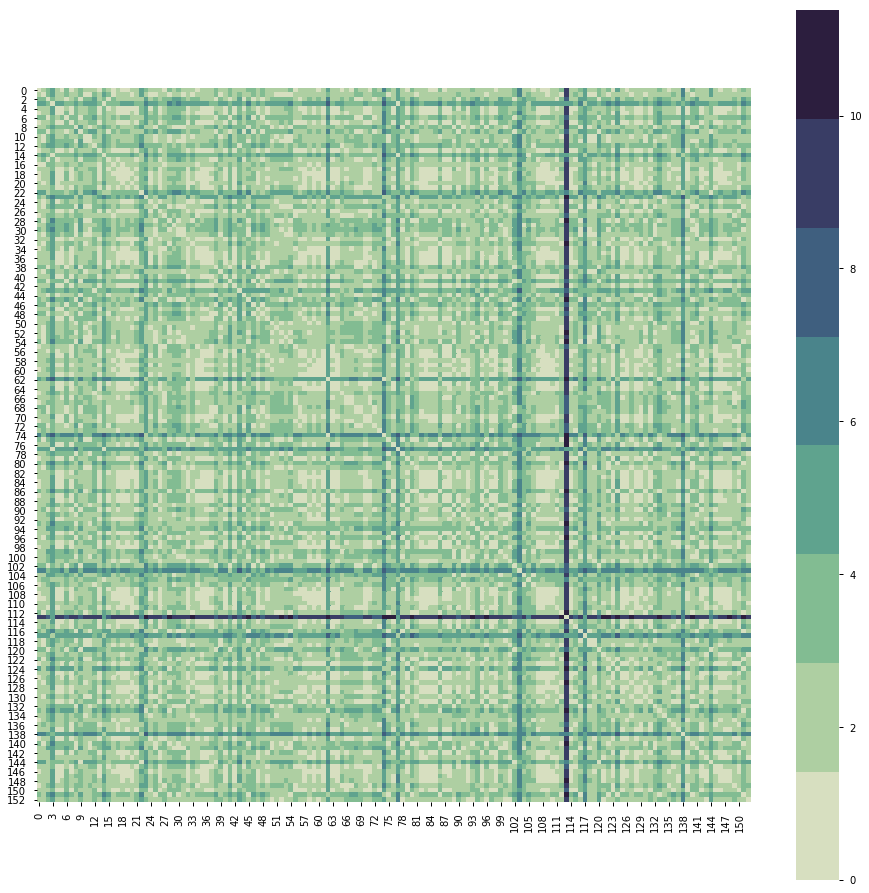

In [92]:
# data_values is the variable containing the data to measure dissimilarity
fig, ax = pl.subplots(figsize=(16, 16))
sns.heatmap(dissimilarity_matrix, square=True,
            cmap=sns.cubehelix_palette(8, start=0.5, rot=-0.75), ax=ax)
pl.show()

In [109]:
# data_values is the variable containing the data to measure dissimilarity
data_heatmap = pd.DataFrame(data=dissimilarity_matrix)
data_heatmap.index = dataset['Country name']
data_heatmap.columns = dataset['Country name']
data_heatmap['cluster'] = best_cluster_labels
data_heatmap.head()

Country name,Afghanistan,Angola,Andorra,United Arab Emirates,Argentina,Armenia,Austria,Azerbaijan,Burundi,Belgium,...,United States of America,Venezuela (Bolivarian Republic of),Viet Nam,Vanuatu,Samoa,Yemen,South Africa,Zambia,Zimbabwe,cluster
Country name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000000,2.052859,3.207439,4.577433,1.982071,1.231795,3.618293,1.331265,2.620954,3.447169,...,4.533458,1.763122,1.228415,2.034741,2.333093,0.629687,1.748197,3.663160,2.494917,0
Angola,2.052859,0.000000,3.282384,4.979858,2.212322,2.281288,3.505810,2.405576,1.612434,3.635887,...,4.530876,2.406499,1.562653,2.157812,2.202773,2.509745,2.044313,1.677574,2.053934,1
Andorra,3.207439,3.282384,0.000000,3.923896,1.875165,2.490543,0.842984,2.305515,4.091020,0.666549,...,1.872831,1.720175,2.675565,2.504332,2.520086,3.394840,2.429886,4.443665,3.349622,2
United Arab Emirates,4.577433,4.979858,3.923896,0.000000,4.339162,4.611679,3.766379,4.189316,5.555509,3.423933,...,3.069606,3.850878,4.763558,5.287579,5.399117,4.386888,3.704708,6.152743,5.574572,3
Argentina,1.982071,2.212322,1.875165,4.339162,0.000000,0.973749,2.545650,0.902419,3.324328,2.202753,...,3.146886,0.712773,1.342881,1.205367,1.421178,2.240982,1.090030,3.629936,2.607161,0


In [110]:
sorted_by_cluster = data_heatmap.sort_values(by='cluster', axis=0)
sorted_by_cluster.head()

Country name,Afghanistan,Angola,Andorra,United Arab Emirates,Argentina,Armenia,Austria,Azerbaijan,Burundi,Belgium,...,United States of America,Venezuela (Bolivarian Republic of),Viet Nam,Vanuatu,Samoa,Yemen,South Africa,Zambia,Zimbabwe,cluster
Country name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000000,2.052859,3.207439,4.577433,1.982071,1.231795,3.618293,1.331265,2.620954,3.447169,...,4.533458,1.763122,1.228415,2.034741,2.333093,0.629687,1.748197,3.663160,2.494917,0
Namibia,1.391414,1.872823,2.369293,4.754373,0.997392,0.702454,2.897630,0.993757,2.623633,2.794869,...,3.850823,1.070914,0.481756,0.711934,0.996134,1.867664,1.361181,3.324235,1.823295,0
Malaysia,2.144318,2.711216,1.960809,3.976190,0.712916,1.153439,2.628550,0.903176,3.680219,2.152829,...,2.924584,0.621970,1.664245,1.612256,1.811965,2.303535,0.997932,4.151298,2.893207,0
Mauritius,1.815208,2.406909,1.981304,4.522866,0.502147,0.666435,2.667358,0.717436,3.346447,2.344662,...,3.366567,0.689658,1.220174,1.002238,1.285157,2.092395,1.297520,3.858888,2.494397,0
Montenegro,1.729311,1.808517,2.350041,4.630494,1.364108,1.332310,2.720112,1.497478,2.251379,2.799861,...,3.741804,1.295464,0.629706,0.987515,1.010697,2.257113,1.449910,3.096103,1.314149,0


In [ ]:
fig, ax = pl.subplots(figsize=(16, 16))

sns.heatmap(sorted_by_cluster, square=True,
            cmap=sns.cubehelix_palette(8, start=0.5, rot=-0.75), ax=ax)
pl.show()

In [ ]:
# data_values is the variable containing the data to measure similarity
fig, ax = pl.subplots(figsize=(16, 16))
sns.heatmap(similarity_matrix, square=True,
            cmap=sns.cubehelix_palette(8, start=0.5, rot=-0.75), ax=ax)
pl.show()

## Analisi PCA per la varianza spiegata

Vediamo il contributo di ogni feature alla varianza spiegata dei dati:

In [ ]:
pca = PCA(n_components=None)
X_pca = pca.fit_transform(dataset_std.loc[:,['CO2',
                                             'Charcoal',
                                             'Clean energy',
                                             'PM2.5',
                                             'GDP']])
pca.explained_variance_ratio_

In [ ]:
pca_ns = PCA(n_components=None)
X_pca_ns = pca_ns.fit_transform(dataset.loc[:,['CO2',
                                             'Charcoal',
                                             'Clean energy',
                                             'PM2.5',
                                             'GDP']])
pca_ns.explained_variance_ratio_

In [ ]:
def plot_explained_variance(pca_obj, threshold=0.9, despine=False):
    n = len(pca_obj.explained_variance_ratio_)
    x_vals = np.arange(n)
    
    # bar chart
    pl.bar(x_vals,
           pca_obj.explained_variance_ratio_,
           alpha=0.5,
           align="center",
           label="Varianza spiegata attributo")
    
    # step plot
    pl.step(x_vals,
            np.cumsum(pca_obj.explained_variance_ratio_),
            where="mid",
            label="Varianza spiegata cumulata")
    
    # threshold
    p = pl.plot(x_vals,
           threshold * np.ones(x_vals.shape),
           linestyle='--',
           label="Soglia al {}%".format(threshold * 100))
    
    pl.xlabel("Componenti principali")
    pl.ylabel("Rapporto varianza spiegata")
    pl.legend(loc="center right")
    if despine:
        sns.despine()
        
    pl.show()
    return p

In [ ]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('poster')
        
    fig, ax = pl.subplots(ncols=1, figsize=(12, 10))
    plot_explained_variance(pca, threshold=0.95, despine=True)
    
    if export_images:
        fig.savefig(img_folder + 'varianza-spiegata.png', bbox_inches='tight')
        sns.set_context('notebook')

In [ ]:
with sns.axes_style(style):
    if export_images:
        sns.set_context('poster')
        
    fig, ax = pl.subplots(nrows=1, ncols=1, figsize=(12, 10))
    plot_explained_variance(pca_ns, threshold=0.95, despine=True)
    
    if export_images:
        fig.savefig(img_folder + 'varianza-spiegata-non-std.png', bbox_inches='tight')
        sns.set_context('notebook')

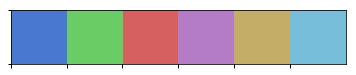

In [66]:
sns.palplot(sns.color_palette('muted'))

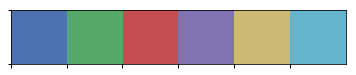

In [70]:
sns.palplot(sns.color_palette('deep'))

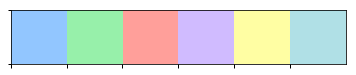

In [71]:
sns.palplot(sns.color_palette('pastel'))

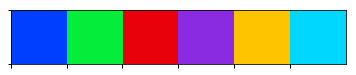

In [72]:
sns.palplot(sns.color_palette('bright'))

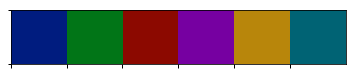

In [73]:
sns.palplot(sns.color_palette('dark'))

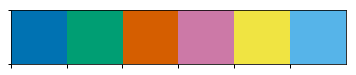

In [74]:
sns.palplot(sns.color_palette('colorblind'))